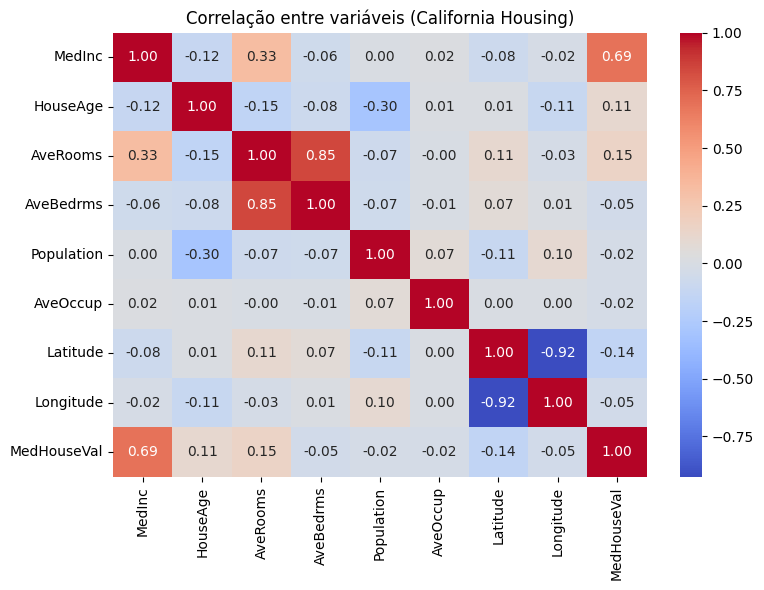

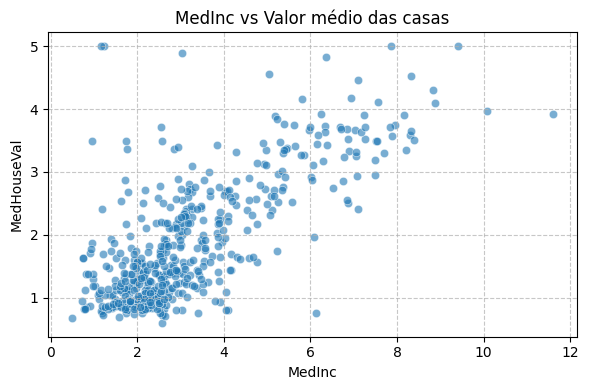

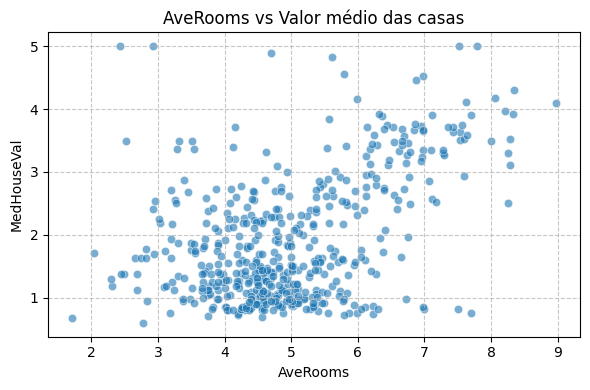

---- Melhores Parâmetros SVR ----
Kernel: rbf
C: 10
Epsilon: 0.2
Melhor MSE SVR: 0.3122
MSE Regressão Linear: 0.3330

Tabela de Resultados (SVR vs LR):
    Kernel      C  Epsilon   MSE_SVR    MSE_LR
0   linear    0.1     0.01  0.331668  0.332955
1   linear    0.1     0.20  0.330540  0.332955
2   linear    0.1     1.00  0.489087  0.332955
3   linear   10.0     0.01  0.333229  0.332955
4   linear   10.0     0.20  0.333494  0.332955
5   linear   10.0     1.00  0.422829  0.332955
6   linear  100.0     0.01  0.333195  0.332955
7   linear  100.0     0.20  0.333486  0.332955
8   linear  100.0     1.00  0.422969  0.332955
9      rbf    0.1     0.01  0.387357  0.332955
10     rbf    0.1     0.20  0.392775  0.332955
11     rbf    0.1     1.00  0.689376  0.332955
12     rbf   10.0     0.01  0.324707  0.332955
13     rbf   10.0     0.20  0.312203  0.332955
14     rbf   10.0     1.00  0.455996  0.332955
15     rbf  100.0     0.01  0.396252  0.332955
16     rbf  100.0     0.20  0.412577  0.332955
17

In [ ]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from sklearn.datasets import fetch_california_housing
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Hiperparâmetros
EPSILONS = (0.01, 0.2, 1)
C_VALUES = (0.1, 10, 100)
KERNELS = ('linear', 'rbf', 'poly')
SELECTED_FEATURES = ["MedInc", "AveRooms"]
SAMPLE_SIZE = 500
TEST_SIZE = 0.3
RANDOM_STATE = 42


def get_california_housing_dataframe() -> pd.DataFrame:
    """Carrega o dataset California Housing e retorna um DataFrame com as features e o target."""
    housing = fetch_california_housing()
    df = pd.DataFrame(housing.data, columns=housing.feature_names)
    df["MedHouseVal"] = housing.target
    return df


def get_features_and_target(df: pd.DataFrame) -> tuple[NDArray, NDArray]:
    """Seleciona as features e o target do DataFrame."""
    X = df[SELECTED_FEATURES].iloc[:SAMPLE_SIZE].values
    y = df["MedHouseVal"].iloc[:SAMPLE_SIZE].values
    return X, y


def plot_features_relationships(df: pd.DataFrame) -> None:
    """Plota mapa de calor da correlação entre as variáveis."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlação entre variáveis (California Housing)")
    plt.tight_layout()
    plt.show()


def plot_features_related_to_target(X: NDArray, y: NDArray, features: list[str]) -> None:
    """Plota relação scatter plot entre cada feature e o target."""
    for i, feature in enumerate(features):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=X[:, i], y=y, alpha=0.6)
        plt.xlabel(feature)
        plt.ylabel("MedHouseVal")
        plt.title(f"{feature} vs Valor médio das casas")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


def evaluate_models(X_train: NDArray, X_test: NDArray, y_train: NDArray, y_test: NDArray) -> tuple[pd.DataFrame, dict, float]:
    """
    Avalia modelos SVR para diferentes combinações de hiperparâmetros e compara com Regressão Linear.
    Retorna DataFrame com resultados, melhores parâmetros do SVR e MSE da Regressão Linear.
    """
    results = {
        "Kernel": [],
        "C": [],
        "Epsilon": [],
        "MSE_SVR": [],
        "MSE_LR": []
    }

    # Treina Regressão Linear base
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)

    best_hyperparams = {"kernel": None, "C": None, "epsilon": None, "mse": math.inf}

    # Avaliação SVR em grid search simples
    for kernel in KERNELS:
        for C in C_VALUES:
            for epsilon in EPSILONS:
                svr = SVR(kernel=kernel, C=C, epsilon=epsilon)
                svr.fit(X_train, y_train)
                y_pred_svr = svr.predict(X_test)
                mse_svr = mean_squared_error(y_test, y_pred_svr)

                results["Kernel"].append(kernel)
                results["C"].append(C)
                results["Epsilon"].append(epsilon)
                results["MSE_SVR"].append(mse_svr)
                results["MSE_LR"].append(mse_lr)

                if mse_svr < best_hyperparams["mse"]:
                    best_hyperparams.update(kernel=kernel, C=C, epsilon=epsilon, mse=mse_svr)

    return pd.DataFrame(results), best_hyperparams, mse_lr


def plot_svr_results(params_df: pd.DataFrame, mse_lr: float) -> None:
    """Plota boxplot do MSE por kernel do SVR, com linha do MSE da regressão linear."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Kernel", y="MSE_SVR", data=params_df, palette="pastel")

    plt.axhline(mse_lr, color="red", linestyle="--", label=f"MSE Regressão Linear ({mse_lr:.3f})")

    # Anotar menor MSE por kernel
    kernels = params_df["Kernel"].unique()
    for i, kernel in enumerate(kernels):
        min_mse = params_df.loc[params_df["Kernel"] == kernel, "MSE_SVR"].min()
        plt.text(i, min_mse - 0.015, f"{min_mse:.3f}", ha='center', color='blue', fontsize=10)

    plt.title("Distribuição do Erro (MSE) por Kernel no SVR")
    plt.xlabel("Kernel")
    plt.ylabel("Erro Quadrático Médio (MSE)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Carregar dados
df = get_california_housing_dataframe()

# Relação entre as features
plot_features_relationships(df)

# Seleção e amostragem dos dados

X, y = get_features_and_target(df)

plot_features_related_to_target(X, y, SELECTED_FEATURES)

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Avaliação dos modelos
params_df, best_hyperparams, mse_lr = evaluate_models(X_train, X_test, y_train, y_test)

# Resultados
print("---- Melhores Parâmetros SVR ----")
print(f"Kernel: {best_hyperparams['kernel']}")
print(f"C: {best_hyperparams['C']}")
print(f"Epsilon: {best_hyperparams['epsilon']}")
print(f"Melhor MSE SVR: {best_hyperparams['mse']:.4f}")
print(f"MSE Regressão Linear: {mse_lr:.4f}\n")

print("Tabela de Resultados (SVR vs LR):")
print(params_df)

# plot_svr_results(params_df, mse_lr)


https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

Prever o valor médio das casas em uma determinada área da Califórnia